In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-self-attention

# Chuẩn bị dữ liệu

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.initializers import GlorotNormal
import tensorflow as tf
from keras.regularizers import l2

In [70]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML-dataset/DGA/RNN/dataset_all.csv')
df

,Unnamed: 0,domain,class
0,0,google.com,legit
1,1,facebook.com,legit
2,2,youtube.com,legit
3,3,baidu.com,legit
4,4,yahoo.com,legit
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


In [72]:
# Trộn dữ liệu
shuffled_data = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Mã hóa nhãn lớp
label_encoder = LabelEncoder()
# Gán 0 cho nhãn 'legit' và 1 cho các lớp DGA khác
shuffled_data['class'] = shuffled_data['class'].apply(lambda x: 0 if x == 'legit' else 1)
encoded_class = shuffled_data['class'].values

# Mã hóa tên miền
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(shuffled_data['domain'])
encoded_domain = tokenizer.texts_to_sequences(shuffled_data['domain'])

# Lấp đầy các chuỗi để đảm bảo độ dài đồng nhất
max_sequence_length = max([len(seq) for seq in encoded_domain])
padded_domain = pad_sequences(encoded_domain, maxlen=max_sequence_length)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(padded_domain, encoded_class, test_size=0.2, random_state=42)

# Xác định kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1  # Thêm 1 vì chỉ số 0 được dành riêng

In [73]:
# Creating model results
ML_Model = []
acc = []
prec = []
rec = []
f1_scores = []

#storing the results
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  acc.append(round(a, 3))
  prec.append(round(b, 3))
  rec.append(round(c, 3))
  f1_scores.append(round(d, 3))

# So sánh với các phương pháp khác để phân loại nhị phân

# AB

In [75]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Khởi tạo mô hình cây quyết định yếu (weak learner)
weak_learner = DecisionTreeClassifier(max_depth=1)

# Khởi tạo mô hình AdaBoost với 50 cây quyết định và thuật toán SAMME.R
model = AdaBoostClassifier(
    base_estimator=weak_learner,
    n_estimators=50,
    algorithm='SAMME.R',
    random_state=42
)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_ab = f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [76]:
storeResults('AB', accuracy, precision, recall, f1_ab)

# NN

In [ ]:
# Khởi tạo mô hình Sequential
model = Sequential()

# Thêm lớp ẩn với 100 nút và hàm kích hoạt ReLU
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

# Thêm lớp đầu ra với số nút bằng số lớp (giả sử đây là bài toán phân loại nhiều lớp)
# Ở đây sử dụng hàm softmax cho phân loại nhiều lớp
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Biên dịch mô hình với bộ tối ưu hóa Adam, learning rate 0.001 và hàm mất mát categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính các chỉ số đo lường hiệu suất
accuracy_nn = accuracy_score(y_test, y_pred_classes)
precision_nn = precision_score(y_test, y_pred_classes, average='weighted')
recall_nn = recall_score(y_test, y_pred_classes, average='weighted')
f1_nn = f1_score(y_test, y_pred_classes, average='weighted')

In [77]:
storeResults('NN', accuracy_nn, precision_nn, recall_nn, f1_nn)

# RF

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Khởi tạo mô hình RandomForest với các tham số cụ thể
rf_model = RandomForestClassifier(
    n_estimators=10,             # Số lượng cây
    max_features=5,              # Số lượng thuộc tính tối đa tại mỗi lần phân tách
    min_samples_split=5,         # Không phân tách các tập con nhỏ hơn 5
    random_state=42
)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')

In [78]:
storeResults('RF', accuracy_rf, precision_rf, recall_rf, f1_rf)

# SVM

In [8]:
from sklearn.svm import SVC
svm_model = SVC(
    C=1.0,               # Tham số C
    kernel='rbf',        # Sử dụng RBF kernel
    gamma='scale',       # Sử dụng gamma='scale' theo mặc định của scikit-learn
    tol=0.10,            # Epsilon (E) = 0.10
    random_state=42
)

# Huấn luyện mô hình
svm_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = svm_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred, average='weighted')
recall_svm = recall_score(y_test, y_pred, average='weighted')
f1_svm = f1_score(y_test, y_pred, average='weighted')

In [79]:
storeResults('SVM', accuracy_svm, precision_svm, recall_svm, f1_svm)

# DT

In [48]:
from sklearn.tree import DecisionTreeClassifier
# Khởi tạo mô hình Decision Tree với các tham số cụ thể
dt_model = DecisionTreeClassifier(
    min_samples_leaf=2,      # Ít nhất hai mẫu trong các lá
    min_samples_split=5,     # Không chia nhỏ các cây nhỏ hơn năm
    max_depth=100,           # Độ sâu tối đa là 100
    max_leaf_nodes=None,     # Không giới hạn số lượng lá
    criterion='gini',        # Sử dụng tiêu chí Gini (có thể thay bằng 'entropy' nếu muốn)
    random_state=42
)

# Huấn luyện mô hình
dt_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = dt_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred, average='weighted')
recall_dt = recall_score(y_test, y_pred, average='weighted')
f1_dt = f1_score(y_test, y_pred, average='weighted')

In [80]:
storeResults('DT', accuracy_dt, precision_dt, recall_dt, f1_dt)

# KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
# Khởi tạo mô hình k-Nearest Neighbours với các tham số cụ thể
knn_model = KNeighborsClassifier(
    n_neighbors=5,            # Sử dụng 5 hàng xóm
    metric='euclidean',       # Sử dụng khoảng cách Euclidean
    weights='uniform'         # Sử dụng trọng số đồng nhất
)

# Huấn luyện mô hình
knn_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = knn_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred, average='weighted')
recall_knn = recall_score(y_test, y_pred, average='weighted')
f1_knn = f1_score(y_test, y_pred, average='weighted')

In [81]:
storeResults('KNN', accuracy_knn, precision_knn, recall_knn, f1_knn)

# LA_Bin07

In [25]:
from keras.models import load_model
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the model with custom objects
custom_objects = {'SeqSelfAttention': SeqSelfAttention, 'SeqWeightedAttention': SeqWeightedAttention}
la_bin07 = load_model('/content/drive/MyDrive/ML/AADR_LA_Bin07.h5', custom_objects=custom_objects)

# Predict on the test set
y_pred = (la_bin07.predict(X_test) > 0.5).astype("int32")

# Calculate performance metrics
accuracy_la = accuracy_score(y_test, y_pred)
precision_la = precision_score(y_test, y_pred, average='weighted')
recall_la = recall_score(y_test, y_pred, average='weighted')
f1_la = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy_la}')
print(f'Precision: {precision_la}')
print(f'Recall: {recall_la}')
print(f'F1 Score: {f1_la}')


11250/11250 [==============================] - 890s 79ms/step
Accuracy: 0.9904
Precision: 0.9904009711880205
Recall: 0.9904
F1 Score: 0.9903984243734394


In [82]:
storeResults('LA_Bin07', accuracy_la, precision_la, recall_la, f1_la)

# So sánh

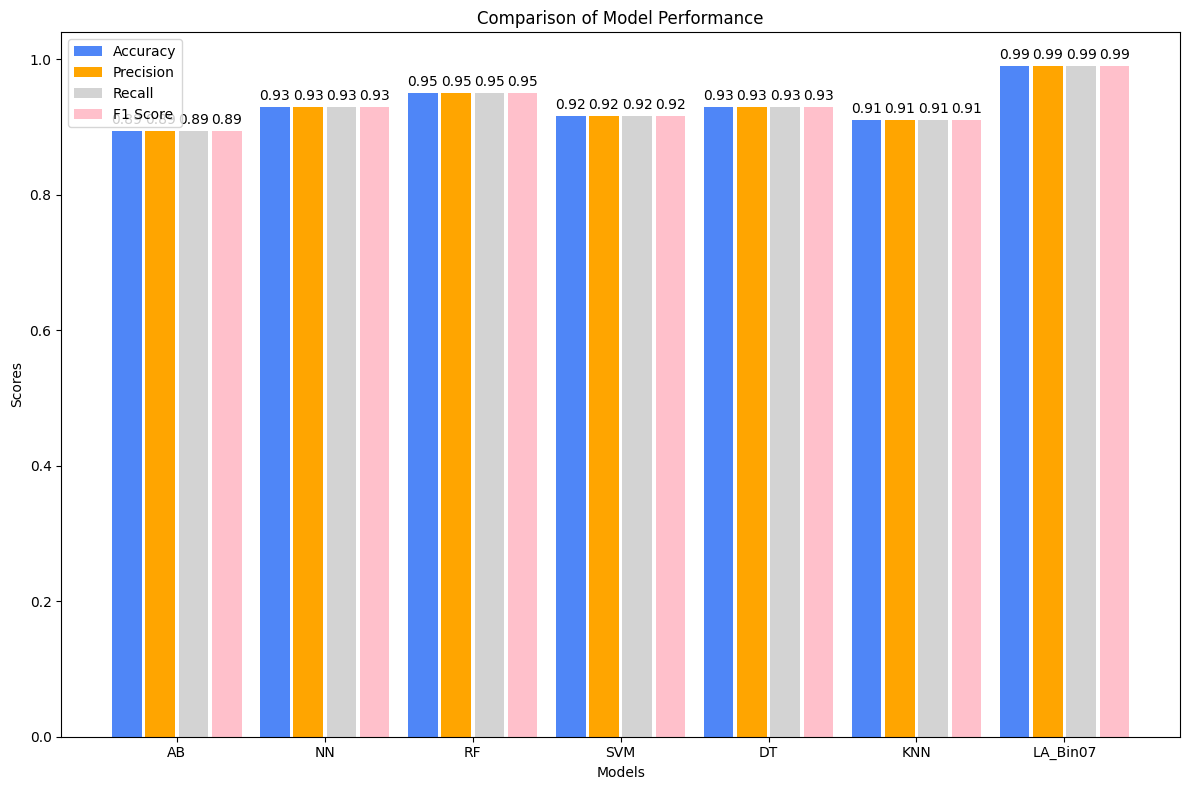

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa tên các mô hình và các chỉ số của chúng
labels = ['AB', 'NN', 'RF', 'SVM', 'DT', 'KNN', 'LA_Bin07']
accuracy = acc
precision = prec
recall = rec
f1_score_1 = f1_scores

# Định nghĩa chiều rộng và khoảng cách giữa các thanh
width = 0.2
space = 0.1

# Định nghĩa vị trí của các thanh
x = np.arange(len(labels))

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 1.5*(width + space/4), accuracy, width, label='Accuracy', color='#4F86F7')
rects2 = ax.bar(x - 0.5*(width + space/4), precision, width, label='Precision', color='orange')
rects3 = ax.bar(x + 0.5*(width + space/4), recall, width, label='Recall', color='#D3D3D3')
rects4 = ax.bar(x + 1.5*(width + space/4), f1_score_1, width, label='F1 Score', color='#FFC0CB')

# Thêm các nhãn cho trục, tiêu đề và các nhãn cho trục x
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hàm để thêm nhãn giá trị trên các thanh
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Hiển thị giá trị với 2 chữ số thập phân
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Dịch chuyển thẳng đứng 3 điểm
                    textcoords="offset points",
                    ha='center', va='bottom')

# Áp dụng hàm autolabel cho tất cả các thanh
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()
